In [113]:
#Following code processed data into
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour (via graphs)
#3. duration of contractions
#4. relaxation time

In [114]:
#packages

#import python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import peak_widths
import peakutils

In [115]:
#assigning filename handles to filenames

#assign filename variable
#example input: 2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv
filename = input("Input filename:" )
#assign variable for excel reference file
ref_filename = "./Myometrial Contractility Reference.txt"
#assign variable for comments file
comments_filename = filename[0:-4] + "_comments" + ".txt"

Input filename:2018_08_13_Human_Uterine.tsv


In [116]:
#importing files and processing

#import muscle bath tsv file
df_file = pd.read_csv(filename, sep='\t')
#import data from excel reference file
df_ref = pd.read_csv(ref_filename, sep='\t')
#import corresponding comments file
comments_file = open(comments_filename,'r')
#process comments
cment_time = []
cment_txt = []
for line in comments_file:
    line = line.rstrip()
    line = line.split(sep = '\t')
    cment_time.append(line[0])
    cment_txt.append(line[1])
#drop unneccessary columns from muscle bath force file
df_file = df_file.drop(columns=['Timestamp','Stimulus'])
#set experiment time as index
df_file.set_index('Experiment Time', inplace = True)
#find filename in reference dataframe
df_ref = df_ref[df_ref['Filename'] == filename]
#drop extra columns
df_ref = df_ref[df_ref.columns[0:14]]
#check to see if muscle bundle should be excluded
df_ref = df_ref[df_ref["EXCLUDE SAMPLE"] != 1]
#reset df_ref index, starting at 0
#this enables easier indexing
df_ref.set_index([pd.Index(list(range(len(df_ref))))])

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),Width1(mm),Width2(mm),Mass (mg),EXCLUDE SAMPLE
0,2018_08_13_Human_Uterine.tsv,1,1,2,NaN,0.0,0.0,Adiponectin,100.0,25.97,2.49,2.77,142.0,NaN


In [117]:
#Determining when baseline ends and treatment begins

#print comments with timepoints
for counter, value in enumerate(cment_time):
    print(cment_txt[counter],":",value)
#create a list of the column names where muscle bath force values are stored
Force_list = ["Force1","Force2","Force3","Force4","Force5","Force6","Force7","Force8"]
#create a placeholder list for storing arrays of force data
baseline_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve baseline force data
#send array of each muscle bath baseline force data to baseline_array_list
#also create a placeholder list for treatment starttime to be later used in treatment peak analysis
treat_time_list = []
count = 0
for bath in df_ref['Bath Number']:
    print('Muscle Bath',bath,':')
    baseline_endtime = int(float(input("What time is treatment added?")))
    if bath < 9:
        baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[bath-1]])
    elif bath > 16:
        baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[bath-17]])
    else:
        baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[bath-9]])
    baseline_array_list.append(baseline_array)
    treat_time_list.append(baseline_endtime)
    count += 1

Pitocin : 13238.0
Baseline : 13536.6
Treatment : 18553.8
Recovery : 19098.9
Muscle Bath 2 :
What time is treatment added?18553.8


In [118]:
rel_height = 0.80

# 1 HOUR BASELINE


#### Baseline Graphs

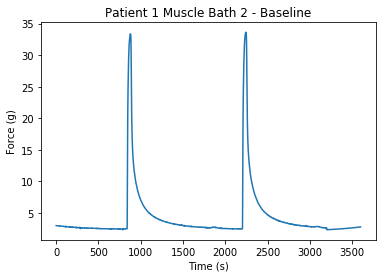

patient1_bath2_baseline.pdf


In [130]:
##### Graphs for 1 hour baseline

#plot the baseline contraction force data from
#for bath in df_ref['Bath Number']:
for i in range(len(baseline_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath)
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Baseline")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    #save baseline plots as pdf file
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print(savestring)
    f.savefig('baseline_graphs/'+savestring,sep = '')

#### Edge Clipping

Before Edge Clipping


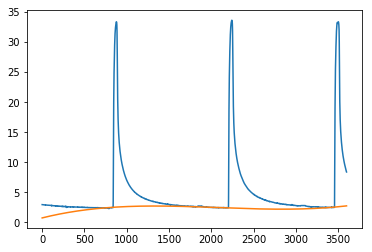

After Edge Clipping


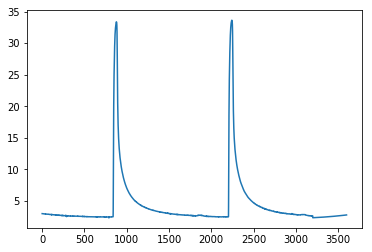

In [120]:
#plot muscle bath baseline contractions; overlay baseline/passive tension
print("Before Edge Clipping")
for mb in range(len(baseline_array_list)):
    baseline_array_list[mb] = (np.array(baseline_array_list[mb]))
    plt.plot((baseline_array_list[mb]))
    plt.plot(peakutils.baseline(np.array(baseline_array_list[mb])))
    plt.show()

#edge clipping
#baseline_array_list[2][3300:] = baseline_array_list[2][3300]
#baseline_array_list[4][3300:] = baseline_array_list[4][3300]
#baseline_array_list[0][3200:] = peakutils.baseline(np.array(baseline_array_list[0]))[3200:]

#replotting graphs to see the effect of clipping the edges
print("After Edge Clipping")
for mb in range(len(baseline_array_list)):
    plt.plot((baseline_array_list[mb]))
    plt.show()   

#### Find Peaks

In [121]:
#loop through muscle baths in reference dataframe 
    #for each bath listed in the reference file, find the local max 
    #for the 1 hr of baseline in the muscle bath file
    #ask when baseline ended for each bath and count backwords 1hr
#create storage lists for outputs
locmax_list = []
fp_output_list = []
#for loop for peak analysis
#vary width variable for each study to tune the find_peaks function
#width_var = float(input("input the width variable for find_peaks function:"))
width_var = 30
for i in range(len(baseline_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath,":")
    #input the height cut off for peak analysis
    #print 90% peak level
    #commented out for automatic peak cutoff input:
    #print("25% of peak",max(baseline_array_list[i]) - ((max(baseline_array_list[i])-min(baseline_array_list[i]))*.75))
    #cutoff = float(input("input peak height cutoff:"))
    #automatic calculation of peak cutoff
    peak25 = max(baseline_array_list[i]) - ((max(baseline_array_list[i])-min(baseline_array_list[i]))*.75)
    cutoff = float(peak25)
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    fp_output = find_peaks(np.array(baseline_array_list[(i)]),height = cutoff, width = width_var)
    locmax = np.array(baseline_array_list[(i)])[fp_output[0]]
    locmax_list.append(locmax)
    fp_output_list.append(fp_output)
    
    
    
#width variable used for analysis of each study: 




#width_var = 30 for 2018_08_13_Human_Uterine.tsv
#width_var = 30 for 2018_08_13_Myometrial_Contractility_Study_1_MB_9_16.tsv
#width_var = 20 for 2018_08_17_Myometrial_Contractility_Study_3_MB_1_8.tsv
#width_var = 20 for 2018_08_17_Myometrial_Contractility_Study_3_MB_1_8.tsv
#width_var = 20 for 2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv
#width_var = 5 for 2018_08_24_Myometrial_Contractility_Study_5_MB_1_8.tsv
#width_var = 5 for 2018_08_31_Myometrial_Contractility_Study_6_MB_1_8.tsv
#width_var = 20 for 2018_09_05_Myometrial_Contractility_Study_7_MB_1_8.tsv
#width_var = 5 for 2018_09_06_Myometrial_Contractility_Study_8_MB_1_8.tsv
#width_var = 20 for 2018_09_06_Myometrial_Contractility_Study_8_MB_17_24.tsv
#width_var = 20 for 2018_09_12_Myometrial_Contractility_Study_9_MB_9_16.tsv
#width_var = 5 for 2018_09_18_Myometrial_Contractility_Study_10_MB_9_16_Restart_Restart.tsv
#width_var = 5 for 2018_09_18_Myometrial_Contractility_Study_10_MB_17_24.tsv
#width_var = 30 for 2018_09_21_Myometrial_Contractility_Study_11_MB_1_8.tsv
#width_var = 20 for 2018_09_21_Human_Uterine_Stimulation.tsv
#width_var = 30 for 2018_09_21_Myometrial_Contractility_Study_11_MB_17_24.tsv
#width_var = 8 for 2018_09_28_Myometrial_Contractility_Study_13_MB_1_8.tsv
#width_var = 10 for 2018_12_07_Myometrial_Contractility_Study_14_b.tsv

In [122]:
# processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_list = []
for i in range(len(fp_output_list)):
    locmax_indx_list.append(fp_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_list = []
for i in range(len(fp_output_list)):
    locmax_dic_list.append(fp_output_list[i][1])

#### Peak Analysis Graphs

Muscle Bath 2


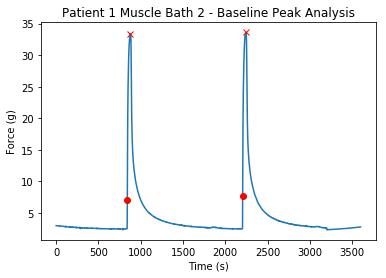

saved as: peakanalysisgraph_patient1_bath2_baseline.pdf
contraction baseline forces: [7.065 7.69 ]


In [131]:
#contraction baseline force determination, peak analysis graphs

#create list for contraction baseline forces
base = []
#loop through muscle baths 
for mb in range(len(df_ref)):
    #determine bath number
    bath = df_ref.iloc[mb]["Bath Number"]
    print("Muscle Bath",bath)
    #create figure to plot on
    f = plt.figure()
    #plot baseline force data for each muscle bath
    plt.plot(np.array(baseline_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Baseline Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    #use peak_widths function to determine the widths of contractions
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],rel_height = rel_height)
    #create storage list for contraction baseline force
    storagelist = []
    #loop through each contraction, use info stored in widths variable
    #from the peak_widths function to determine the left baseline force 
    for contract_num in range(len(locmax_indx_list[mb])):
        #determine left baseline indx
        left_basex = int(widths[2][contract_num])
        #determine left baseline force
        left_basey = np.array(baseline_array_list[mb])[left_basex]
        #plot left baseline force on plot
        plt.plot(left_basex,left_basey,'ro')
        #store this muscle baths contraction baseline forces
        storagelist.append(left_basey)
    #loop through contraction peaks and plot the maximum
    for counter, peak in enumerate(locmax_list[mb]):
        plt.plot(locmax_indx_list[mb][counter],peak,'rx')
    plt.show()
    #save plots as pdf
    savestring = "peakanalysisgraph_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print("saved as:",savestring)
    f.savefig('baseline_graphs/'+savestring,sep = '')
    #store contraction baseline forces
    base.append(np.array(storagelist))
    print("contraction baseline forces:",base[mb])
    

#### Peak Force Amplitude & Peak Force Amplitude Corrected to CSA

In [124]:
#baseline peak force calculations

#create an empty list to store raw forces and titles
raw_force_list = []
forcetitles = []
#calculate baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    forcetitles.append(title)
    for contract in range(len(locmax_list[x])):
        amp = (locmax_list[x][contract]-base[x][contract])
        templist.append(amp)
    raw_force_list.append(np.array(templist))
#make a dictionary out of titles and raw forces    
rawforcedic = dict(zip(forcetitles, raw_force_list))
#for each muscle bath calculate the average raw peak value during baseline
#this will be used for treatment peak normalization
#create empty storage lists 
basepeakmean = []
#for loop calculation 
for bath in range(len(raw_force_list)):
    basepeakmean.append(raw_force_list[bath].mean())  
#calculate cross-sectional area (CSA)
CSA_list = []
for bath in df_ref['Bath Number']:
    length = float(df_ref[df_ref['Bath Number']== bath]['Length (mm)'])
    mass = float(df_ref[df_ref['Bath Number']== bath]['Mass (mg)'])   
    CSA = ((mass*.001)/(1.056*length*.1)) * 100       #CSA in mm2
    CSA_list.append(CSA)
print((CSA_list))
#create an empty list to store CSA normalized forces and titles
norm_force_list = []
normtitles = []
#calculate CSA normalized baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" norm (g/mm2)"
    normtitles.append(title)
    for contraction in range(len(locmax_list[x])):
        norm = ((locmax_list[x][contraction]-base[x][contraction])/CSA_list[x])
        templist.append(norm)
    norm_force_list.append(np.array(templist))
#make a dictionary out of titles and raw forces    
normforcedic = dict(zip(normtitles, norm_force_list))


[5.177885905648709]


#### Contraction Durations

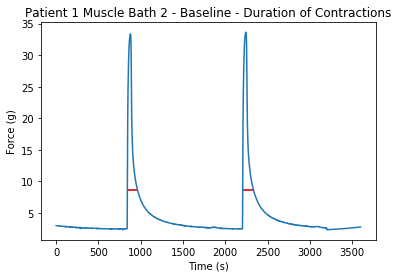

saved as: contractduration_patient1_bath2_baseline.pdf


In [132]:
#calculate duration of contractions
peakduration = []
base_duration_titles = []
for mb in range(len(baseline_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" duration times (s)"
    base_duration_titles.append(title)
    templist = []
    #create figure to plot on
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Baseline - Duration of Contractions")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],rel_height=rel_height)
    for contraction in range(len(locmax_list[mb])):
        leftx = ((widths[2][contraction]))
        rightx = ((widths[3][contraction]))
        templist.append(int(rightx-leftx))
        plt.hlines(*widths[1:], color="C3")
    plt.show()
    peakduration.append(np.array(templist))
    #save plots as pdf
    savestring = "contractduration_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print("saved as:",savestring)
    f.savefig('baseline_graphs/'+savestring,sep = '')
#make a dictionary for baseline contractions duration time    
base_contract_dur_time = dict(zip(base_duration_titles,peakduration))

#### Relaxation Time

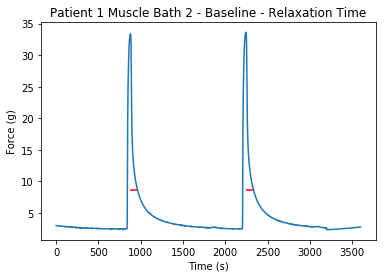

saved as: relaxtime_patient1_bath2_baseline.pdf


In [133]:
#relaxation time
relaxtitle = []
relax_time = []
for mb in range(len(baseline_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" relaxation times (s)"
    relaxtitle.append(title)
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],rel_height=rel_height)
    relax = widths[3]-locmax_indx_list[mb]
    relax = relax.astype(int)
    relax_time.append(relax)
    #create figure to plot on
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Baseline - Relaxation Time")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    for contract_num in range(len(locmax_indx_list[mb])):
        #determine left baseline indx
        right_basex = int(widths[3][contract_num])
        #determine left baseline force
        right_basey = np.array(baseline_array_list[mb])[right_basex]
        #plot left baseline force on plot
        plt.hlines(right_basey,locmax_indx_list[mb][contract_num],right_basex, colors= 'r')
    plt.show()
    #save plots as pdf
    savestring = "relaxtime_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print("saved as:",savestring)
    f.savefig('baseline_graphs/'+savestring,sep = '')
#make a dictionary for baseline contractions duration time    
base_relax_time = dict(zip(relaxtitle,relax_time))

#### Baseline Excel Spreadsheet

In [134]:
#sending baseline data to Excel spreadsheet

#create a dataframe to store raw force data
df_raw = pd.DataFrame.from_dict(rawforcedic, orient='index')
df_raw = df_raw.transpose()
#create a dataframe to store normalized data
df_norm = pd.DataFrame.from_dict(normforcedic, orient='index')
df_norm = df_norm.transpose()
#create a dataframe to store contraction duration time data
df_base_contract_dur = pd.DataFrame.from_dict(base_contract_dur_time, orient='index')
df_base_contract_dur = df_base_contract_dur.transpose()
#create a dataframe to store contraction relaxation time data
df_base_relax = pd.DataFrame.from_dict(base_relax_time, orient='index')
df_base_relax = df_base_relax.transpose()
#create output baseline dataframe
df_base_out = df_raw.join(df_norm)
df_base_out = df_base_out.join(df_base_contract_dur)
df_base_out = df_base_out.join(df_base_relax)
df_base_out.head()
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
base_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_baseline_"+computer+".xlsx"
df_base_out.to_excel(base_out_file)
print(base_out_file)

Patient1_baseline_comp1.xlsx


## 1 HOUR TREATMENT

#### Treatment Graphs

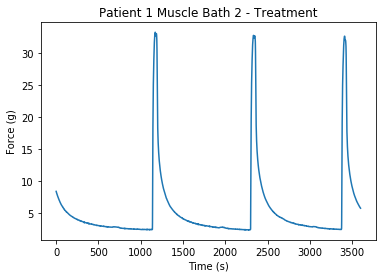

patient1_bath2_treatment.pdf


In [136]:
#create a placeholder list for storing arrays of treatment force data
treat_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve treatment force data
#send array of each muscle bath treatment force data to treat_array_list
count = 0
for bath in df_ref['Bath Number']:
   
    if bath < 9:
        treatment_array = (df_file.loc[treat_time_list[count]:treat_time_list[count]+3599,Force_list[bath-1]])
       
    elif bath > 16: 
        #treatment_array = (df_file.loc[treat_time_list[count]:treat_time_list[count]+3599,Force_list[bath-17]])
        treatment_array = (df_file.loc[treat_time_list[count]:,Force_list[bath-17]])
    else:
        treatment_array = (df_file.loc[treat_time_list[count]:treat_time_list[count]+3599,Force_list[bath-9]])
    
    treat_array_list.append(treatment_array)
    count += 1
#plot the treatment contraction force data
for i in range(len(treat_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath)
    f = plt.figure()
    plt.plot(np.array(treat_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Treatment")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print(savestring)
    f.savefig('treatment_graphs/'+savestring,sep = '')

#### Edge Clipping

Before Edge Clipping


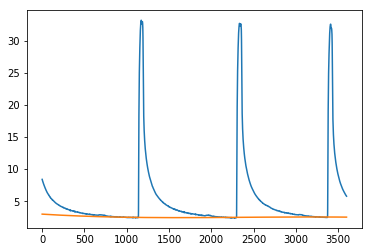

After Edge Clipping


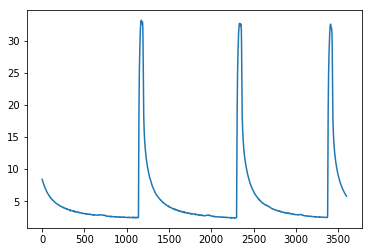

In [137]:
#plot muscle bath baseline contractions; overlay baseline/passive tension
print("Before Edge Clipping")
for mb in range(len(treat_array_list)):
    treat_array_list[mb] = (np.array(treat_array_list[mb]))
    plt.plot((treat_array_list[mb]))
    plt.plot(peakutils.baseline(np.array(treat_array_list[mb])))
    plt.show()

#edge clipping
#treat_array_list[5][3200:] = peakutils.baseline(np.array(treat_array_list[5]))[3200:]
#treat_array_list[6][0:300] = treat_array_list[6][300]
#treat_array_list[0][3500:] = treat_array_list[0][3500]


#replotting graphs to see the effect of clipping the edges
print("After Edge Clipping")
for mb in range(len(treat_array_list)):
    plt.plot((treat_array_list[mb]))
    plt.show()   

#### Find Peaks

In [138]:
#peak analysis for 1 hour treatment
#create storage lists for outputs
treat_locmax_list = []
fp_treat_output_list = []
#for loop for peak analysis
#reuse the width variable defined earlier for baseline peak analysis
for i in range(len(treat_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    #comment out for automatic peak detection
    #print("Muscle Bath",bath,":")
    #print 90% peak level
    #print("25% of peak",max(treat_array_list[i]) - ((max(treat_array_list[i])-min(treat_array_list[i]))*.75))
    #input the height cut off for peak analysis
    #cutoff = float(input("input peak height cutoff:"))
    #automatically determine peak cutoff height 
    peak25 = max(treat_array_list[i][1:-1]) - ((max(treat_array_list[i][1:-1])-min(treat_array_list[i][1:-1]))*.75)
    cutoff = float(peak25)
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    width_var = 20
    fp_output = find_peaks(np.array(treat_array_list[(i)]),height = cutoff, width = width_var)
    locmax = np.array(treat_array_list[(i)])[fp_output[0]]
    treat_locmax_list.append(locmax)
    fp_treat_output_list.append(fp_output)


In [139]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_treat_list = []
for i in range(len(fp_treat_output_list)):
    locmax_indx_treat_list.append(fp_treat_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_treat_list = []
for i in range(len(fp_treat_output_list)):
    locmax_dic_treat_list.append(fp_treat_output_list[i][1])

#### Peak Analysis Graphs

Muscle Bath 2


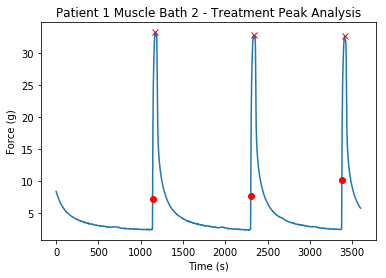

saved as: peakanalysisgraph_patient1_bath2_treatment.pdf
contraction baseline forces: [ 7.175  7.753 10.17 ]


In [140]:
#contraction baseline force determination, peak analysis graphs

#create a list for contration baseline forces
base_treat = []
#loop through muscle baths
for mb in range(len(df_ref)):
    #determine bath number
    bath = df_ref.iloc[mb]["Bath Number"]
    print("Muscle Bath",bath)
    #create figure to plot on
    f = plt.figure()
    #plot baseline force data for each muscle bath
    plt.plot(np.array(treat_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Treatment Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    #use peak_widths function to determine the widths of contractions
    widths = peak_widths(treat_array_list[mb],locmax_indx_treat_list[mb],rel_height=rel_height)
    #create storage list for contraction baseline force
    storagelist = []
    #loop through each contraction, use info stored in widths variable
    #from the peak_widths function to determine the left baseline force 
    for contract_num in range(len(locmax_indx_treat_list[mb])):
        #determine left baseline indx
        left_basex = int(widths[2][contract_num])
        #determine left baseline force
        left_basey = np.array(treat_array_list[mb])[left_basex]
        #plot left baseline force on plot
        plt.plot(left_basex,left_basey,'ro')
        #store this muscle baths contraction baseline forces
        storagelist.append(left_basey)
        #loop through contraction peaks and plot the maximum
    for counter, peak in enumerate(treat_locmax_list[mb]):
        plt.plot(locmax_indx_treat_list[mb][counter],peak,'rx')
    plt.show()
    #save plots as pdf
    savestring = "peakanalysisgraph_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print("saved as:",savestring)
    f.savefig('treatment_graphs/'+savestring,sep = '')
    #store contraction baseline forces
    base_treat.append(np.array(storagelist))
    print("contraction baseline forces:",base_treat[mb])   

#### Peak Force Amplitude & Peak Force Amplitude Corrected to CSA

In [141]:
#treatment peak force calculations
#create an empty list to store the raw treatment peak values
treatpeakvals = []
treatpeaktitles = []
#calculate treatment peak forces
for mb in range(len(treat_locmax_list)):
    #create a temporary list to store each contraction peak for current muscle bath
    templist = []
    for contraction in range(len(treat_locmax_list[mb])):
        amplitude = (treat_locmax_list[mb][contraction]-base_treat[mb][contraction])
        templist.append(amplitude)
    treatpeakvals.append(np.array(templist))
    #create a title for these values. store them in a list 
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    treatpeaktitles.append(title)
#normalizing to baseline function
#create an empty list to store the normalized treatment peak values and titles
normalized_treatment_peaks = []
normtreatpeaktitles = []
#normalize forces to baseline average peak force
for mb in range(len(treatpeakvals)):
    peaks_norm_2_base_function = treatpeakvals[mb]/basepeakmean[mb]
    normalized_treatment_peaks.append(peaks_norm_2_base_function)
    #normalized treatment peaks titles (for column labels in Excel file)
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" normalized to baseline"
    normtreatpeaktitles.append(title)
#normalize forces to CSA    
#create an empty list to store CSA normalized forces and titles
forces_norm_2_CSA_list= []
norm_2_CSA_titles = []
#calculate CSA normalized baseline peak forces
for mb in range(len(treat_locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" norm (g/mm2)"
    norm_2_CSA_titles.append(title)
    for contraction in range(len(treat_locmax_list[mb])):
        norm = ((treat_locmax_list[mb][contraction]-base_treat[mb][contraction])/CSA_list[mb])
        templist.append(norm)
    forces_norm_2_CSA_list.append(np.array(templist))    
#make a dictionary out of titles and raw treatment contraction peaks    
treatpeakdic = dict(zip(treatpeaktitles, treatpeakvals))
#make a dictionary out of titles and normalized treatment contraction peaks
treatnormpeakdic = dict(zip(normtreatpeaktitles, normalized_treatment_peaks))
#make a dictionary out of titles and treatment contraction peaks normalized to CSA
norm2CSA_dic = dict(zip(norm_2_CSA_titles,forces_norm_2_CSA_list))

#### Contraction Durations

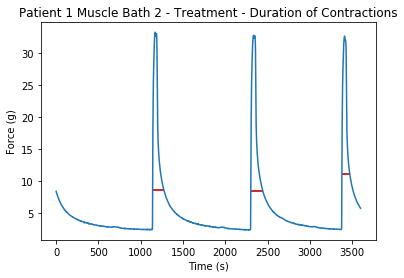

saved as: contractduration_patient1_bath2_treatment.pdf


In [142]:
#calculate duration of contractions
peakdurations = []
treat_duration_titles = []
for mb in range(len(treat_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" duration times (s)"
    treat_duration_titles.append(title)
    templist = []
    #create figure to plot on
    f = plt.figure()
    plt.plot(np.array(treat_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Treatment - Duration of Contractions")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    widths = peak_widths(treat_array_list[mb],locmax_indx_treat_list[mb],rel_height=rel_height)
    for contraction in range(len(treat_locmax_list[mb])):
        leftx = ((widths[2][contraction]))
        rightx = ((widths[3][contraction]))
        templist.append(int(rightx-leftx))
        plt.hlines(*widths[1:], color="C3")
    plt.show()
    peakduration.append(np.array(templist))
    #save plots as pdf
    savestring = "contractduration_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print("saved as:",savestring)
    f.savefig('treatment_graphs/'+savestring,sep = '')
#make a dictionary for treatment contractions duration time    
treat_contract_dur_time = dict(zip(treat_duration_titles,peakduration))

#### Relaxation Time

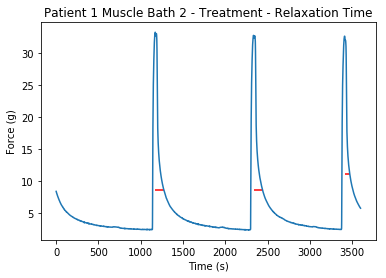

saved as: relaxtime_patient1_bath2_treatment.pdf


In [144]:
#relaxation time 
relaxtitle = []
relax_time = []
for mb in range(len(treat_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" relaxation times (s)"
    relaxtitle.append(title)
    widths = peak_widths(treat_array_list[mb],locmax_indx_treat_list[mb],rel_height=rel_height)
    relax = widths[3]-locmax_indx_treat_list[mb]
    relax = relax.astype(int)
    relax_time.append(relax)
    #create figure to plon on
    f = plt.figure()
    plt.plot(np.array(treat_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Treatment - Relaxation Time")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    for contract_num in range(len(locmax_indx_treat_list[mb])):
        right_basex = int(widths[3][contract_num])
        right_basey = np.array(treat_array_list[mb])[right_basex]
        plt.hlines(right_basey,locmax_indx_treat_list[mb][contract_num],right_basex, colors= 'r')
    plt.show()  
    #save plots as pdf
    savestring = "relaxtime_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print("saved as:",savestring)
    f.savefig('treatment_graphs/'+savestring,sep = '')
#make a dictionary for treatment relaxation time    
treat_relax_time = dict(zip(relaxtitle,relax_time))

In [145]:
#export treatment peak data to Excel spreadsheet
#create a dataframe to store raw force data
df_t_raw = pd.DataFrame.from_dict(treatpeakdic, orient='index')
df_t_raw = df_t_raw.transpose()
#create a dataframe to store normalized data
df_t_norm = pd.DataFrame.from_dict(treatnormpeakdic, orient='index')
df_t_norm = df_t_norm.transpose()
#create a dataframe to store normalized to CSA data
df_t_norm2CSA = pd.DataFrame.from_dict(norm2CSA_dic, orient='index')
df_t_norm2CSA = df_t_norm2CSA.transpose()
#create a dataframe to store contraction duration time data
df_treat_contract_dur = pd.DataFrame.from_dict(treat_contract_dur_time, orient='index')
df_treat_contract_dur = df_treat_contract_dur.transpose()
#create a dataframe to store contraction relaxation time data
df_treat_relax = pd.DataFrame.from_dict(treat_relax_time, orient='index')
df_treat_relax = df_treat_relax.transpose()
#create output baseline dataframe
df_treat_out = df_t_raw.join(df_t_norm)
df_treat_out = df_treat_out.join(df_t_norm2CSA)
df_treat_out = df_treat_out.join(df_treat_contract_dur)
df_treat_out = df_treat_out.join(df_treat_relax)
df_treat_out.head()
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
treat_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_treatment_"+computer+".xlsx"
df_treat_out.to_excel(treat_out_file)
print(treat_out_file)

Patient1_treatment_comp1.xlsx


In [146]:
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour
#3. duration of contractions
#4. relaxation time

In [147]:
comments_file.close()